In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 질문 
  - 왜 BCE 수식 직접 쓰면 안 되지?
    - 과제 해결 할 때 log1p했더니 됐는데 이건 안 되네?
  - underlying에 대한 해석 DNN으로 해결 가능한 다양한 예제 전 부분

## 로지스틱 회귀의 한계 

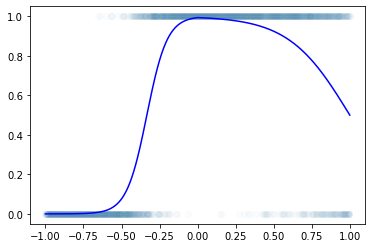

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex0.csv')

plt.plot(df.x,df.y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

### 로지스틱 회귀로 적합

In [7]:
x= torch.tensor(df.x).float().reshape(-1,1)
y= torch.tensor(df.y).float().reshape(-1,1)

net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()   )

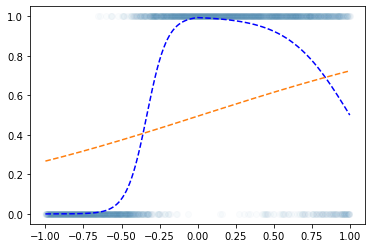

In [8]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--') # 학습 전

In [9]:
loss_fn = torch.nn.BCELoss()
# loss_fn = lambda y,yaht : -torch.mean((y)*torch.log(yhat)+(1-y)*torch.log(1-yhat))
# BCELoss를 직접 넣어주면 학습이 안 되네?,,,,,,,,,,,,,,,,,,,,,,,

In [10]:
optimizr = torch.optim.Adam(net.parameters()) 
# 학습률은 default로 사용중

In [11]:
for epoc in range(6000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad() 

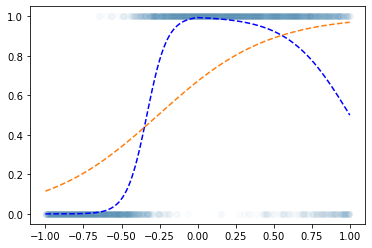

In [12]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--') # 학습 후

- Epoch을 한 6억번 넣어도 이건 못 맞출 것 같다 (증가하다가 감소하는 underlying을 설계하는 것이 불가능)
  - 모형의 표현력이 너무 낮다. 

### 해결책

`-` sigmoid 넣기 전의 상태가 꺽인 그래프 이어야 한다. 

In [14]:
sig = torch.nn.Sigmoid()

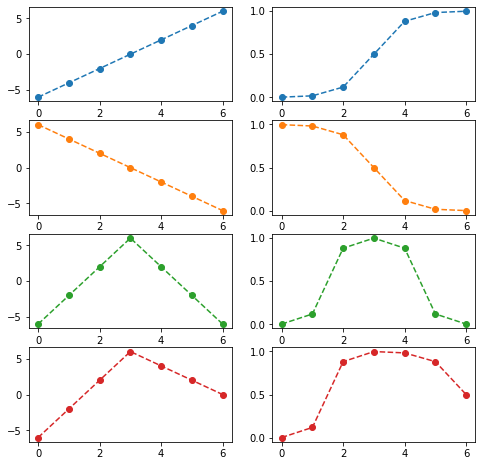

In [15]:
fig,ax = plt.subplots(4,2,figsize=(8,8))
u1 = torch.tensor([-6,-4,-2,0,2,4,6])
u2 = torch.tensor([6,4,2,0,-2,-4,-6])
u3 = torch.tensor([-6,-2,2,6,2,-2,-6])
u4 = torch.tensor([-6,-2,2,6,4,2,0])
ax[0,0].plot(u1,'--o',color='C0');ax[0,1].plot(sig(u1),'--o',color='C0')
ax[1,0].plot(u2,'--o',color='C1');ax[1,1].plot(sig(u2),'--o',color='C1')
ax[2,0].plot(u3,'--o',color='C2');ax[2,1].plot(sig(u3),'--o',color='C2')
ax[3,0].plot(u4,'--o',color='C3');ax[3,1].plot(sig(u4),'--o',color='C3')

# 질문 3

- 즉, 애초에 꺾인 선을 sigmoid에 넣어주면 된다
- 음.. 비유를 해보자면 
  - 애초에 꺾인 선을 sigmoid에 넣어준다
  - 잠재능력이 20인 정도인 trainee를 아무리 숙련시켜봤자 한계는 20
  - 그런데 잠재능력이 200 정도인 trainee를 숙련시키면 한계는 200
  - 즉, 아싸리 학습이 잘 될 조건을 가진 trainee를 넣어주자
  - 그런데 이때 너무 무리해서 아웃 feature가 높은 trainee를 넣어주면 오버피팅의 가능성이 높아진다
  - 그런데 이때 얼마나 꺾을지?는 노드를 결정하는 거고, 그렇다면 오버피팅이 될지 말지를 결정할 그 적당한 노드수는
  - 어떻게 알지?

---

## DNN을 이용한 해결 

`-` 목표: 아래와 같은 벡터 ${\boldsymbol u}$를 만들어보자. 

${\boldsymbol u} = [u_1,u_2,\dots,u_{2000}], \quad u_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$

### 꺽인 그래프를 만드는 방법1 - (낮은 확장성)

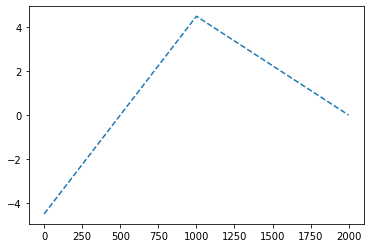

In [18]:
u = [9*xi+4.5 if xi <0 else -4.5*xi+4.5 for xi in x.reshape(-1).tolist()]
plt.plot(u,'--')

### 꺽인 그래프를 만드는 방법2

`-` 전략: 선형변환 $\to$ ReLU $\to$ 선형변환 

***(선형변환1)***

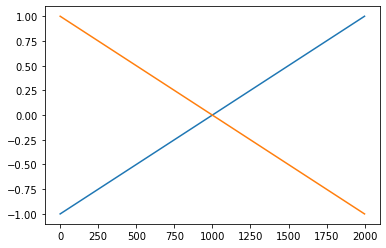

In [22]:
plt.plot(x);plt.plot(-x)

***(렐루)***

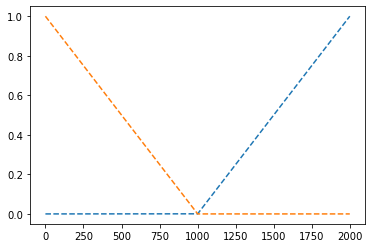

In [23]:
relu=torch.nn.ReLU()
plt.plot(relu(x),'--',color='C0');plt.plot(relu(-x),'--',color='C1')

***(선형변환2)*** (더해준다, 이때 out_features=1로 하는 것!)

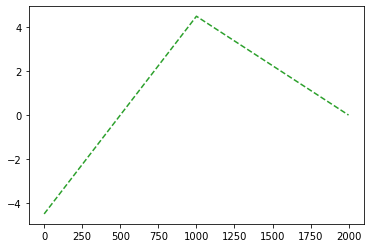

In [24]:
plt.plot(  -4.5*relu(x)  -9.0*relu(-x)+4.5  ,'--',color='C2') # 선형변환 2

- 이제 초록색선에 sig를 취하기만 하면?

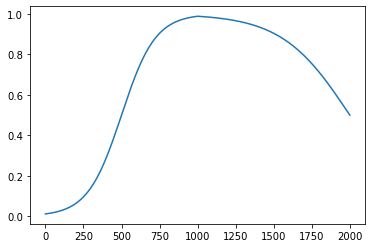

In [25]:
plt.plot(sig(-4.5*relu(x)-9.0*relu(-x)+4.5))
# 이게 yhat!

정리하면!

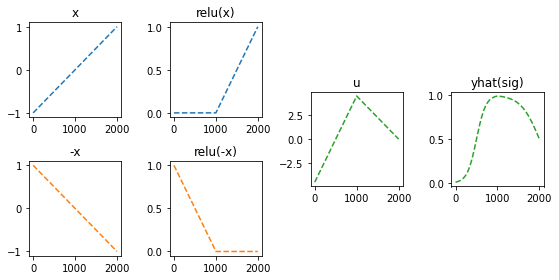

In [33]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title('x'); ax1.plot(x,'--',color='C0')
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title('-x'); ax2.plot(-x,'--',color='C1')
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title('relu(x)'); ax3.plot(relu(x),'--',color='C0')
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title('relu(-x)'); ax4.plot(relu(-x),'--',color='C1')
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title('u'); ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('yhat(sig)'); ax6.plot(sig(-4.5*relu(x)-9*relu(-x)+4.5),'--',color='C2')
fig.tight_layout()

- 이런느낌으로 $\hat{\boldsymbol y}$을 만들면 된다. 

### torch.nn.Linear()를 이용한 꺽인 그래프 구현 

In [26]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(1,2) #선형변환 1 -> 꺾인 선 만드려면 선 두개 필요하니까 out_features = 2
a1 = torch.nn.ReLU() # 렐루
l2 = torch.nn.Linear(2,1) #선형변환 2 -> 꺾인 선 한 개 만들어야 하니깐 out_features = 1
a2 = torch.nn.Sigmoid()  # sigmoid -> yhat

In [27]:
net = torch.nn.Sequential(l1,a1,l2,a2) 

> shape 설정이 좀 이상한데 pytorch에서만 그렇다!

> 전치될 것까지 고려하여 설정해주면 된다

In [28]:
l1.weight,l1.bias,l2.weight,l2.bias

(Parameter containing:
 tensor([[-0.3467],
         [-0.8470]], requires_grad=True),
 Parameter containing:
 tensor([0.3604, 0.9336], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2880, -0.6282]], requires_grad=True),
 Parameter containing:
 tensor([0.2304], requires_grad=True))

In [29]:
# 위에서 반환된 형식대로 weight와 bias를 수정해준다
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0, 0.0])

l2.weight.data = torch.tensor([[ -4.5, -9.0]])
l2.bias.data= torch.tensor([4.5])

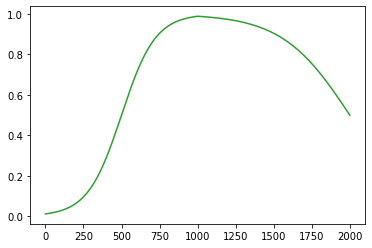

In [35]:
# plt.plot(l1(x).data) # 선형변환 1
# plt.plot(a1(l1(x)).data) # ReLU
# plt.plot(l2(a1(l1(x))).data,color='C2') # 선형변환 2
# plt.plot(a2(l2(a1(l1(x)))).data,color='C2') # 선형변환 2

plt.plot(net(x).data,color='C2') # 위 네줄의 합

# 이게 yhat을 구한 것
# 이제 어떤 x값이 들어오면 이 유사 underlying을 이용해 베르누이?를 이용해서 0일지 1일지 예측하면 되는 것!

# 질문 2 - 위 주석

`-` 수식표현

1. ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$

2. $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\  x_n & -x_n\end{bmatrix}$
    - ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
    - ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$

3. $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\  \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$

4. $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\\ =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots  \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$ 
    - ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
    - $b^{(2)}=4.5$

5. $net({\bf X})=(a_2 \circ l_2 \circ a_1\circ l_1)({\bf X})=\text{sig}\Big(\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\Big)\\=\begin{bmatrix} \text{sig}\Big(-4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5\Big) \\ \text{sig}\Big(-4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \Big)\\ \dots  \\ \text{sig}\Big(-4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \Big)\end{bmatrix}$ 


`-` 차원만 따지자

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}({\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}})$

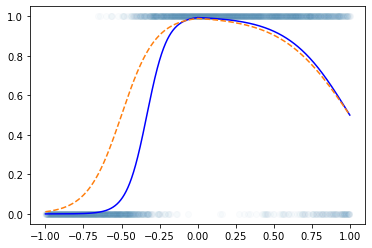

In [36]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')


# 이때 처음부터 이렇게 잘 된 것 애초에 꺾인 선을 parameter를 잘 조작해서 넣어줘서 그런 거고
# 밑에는 그냥 seed에서 할당해준대로 넣어줘서 그런 것!
# 아무튼 꺾은 선 넣어준 건 밑에도 동일
# 그런데 이 예제는 꺾은 선도 넣어주고 애초에 시그모이드에 잘 맞게 기울기값과 편향값까지 조작해서 넣어줬음

### Step1 ~ Step4

`-` 준비

In [46]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,2), #u1=l1(x), x:(n,1) --> u1:(n,2) 
    torch.nn.ReLU(), # v1=a1(u1), u1:(n,2) --> v1:(n,2) 
    torch.nn.Linear(2,1), # u2=l2(v1), v1:(n,2) --> u2:(n,1) 
    torch.nn.Sigmoid() # v2=a2(u2), u2:(n,1) --> v2:(n,1) 
) 

# 그런데 이때 out_features를 2가 아닌 250처럼 큰 수로 해주면 더 잘 맞긴 함
# 근데 이 경우는 복잡한 경우가 아니라 
# 다른 경우엔 오버피팅의 문제가 생길 수 있음

In [47]:
loss_fn = torch.nn.BCELoss()

In [48]:
optimizr = torch.optim.Adam(net.parameters()) # lr은 디폴트값으로..

`-` 반복 

Text(0.5, 1.0, 'before')

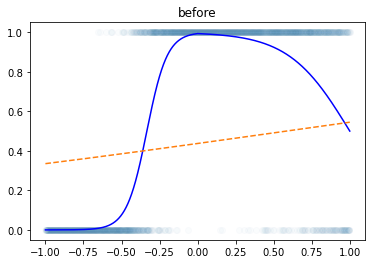

In [49]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')
plt.title("before")

In [54]:
for epoc in range(6000):
    loss = loss_fn(net(x),y) 
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'after 3000 epochs')

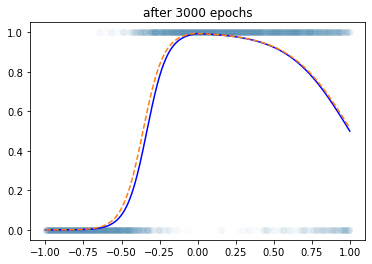

In [55]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--',color='C1')
plt.title("after 3000 epochs")

## DNN으로 해결가능한 다양한 예제

### 예제1

- 언뜻 생각하면 방금 배운 기술은 sig를 취하기 전이 꺽은선인 형태만 가능할 듯 하다.
  - 그래서 이 역시 표현력이 부족할 듯 하다.
  - 그런데 생각보다 표현력이 풍부한 편이다. 
    - 즉 생각보다 쓸 만하다. 

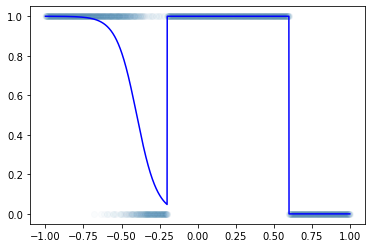

In [85]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex1.csv')
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)

plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

- 이거 시그모이드 취하기 직전은 step이 포함된 듯 $\to$ 그래서 꺽은선으로는 표현할 수 없는 구조임 $\to$ 그런데 사실 대충은 표현가능 

In [76]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=16), # x:(n,1) --> u1:(n,16) 
    torch.nn.ReLU(), # u1:(n,16) --> v1:(n,16)
    torch.nn.Linear(in_features=16,out_features=1), # v1:(n,16) --> u2:(n,1) 
    torch.nn.Sigmoid() # u2:(n,1) --> v2:(n,1) 
)

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,16)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,16)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [77]:
loss_fn = torch.nn.BCELoss()

In [78]:
optimizr = torch.optim.Adam(net.parameters())

In [79]:
for epoc in range(6000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()    

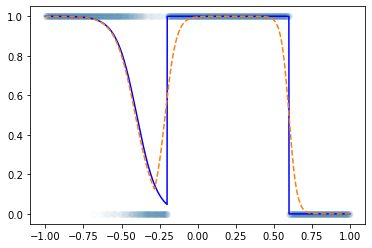

In [80]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

### 예제2

`-` 사실 꺽은선의 조합으로 꽤 많은걸 표현할 수 있거든요? $\to$ 심지어 곡선도 대충 맞게 적합된다. 

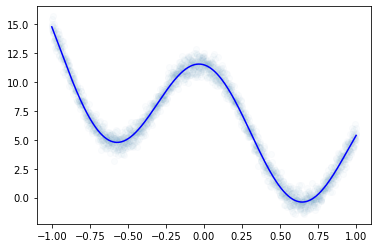

In [86]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex2.csv')

x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)

plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

(풀이1)

In [87]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32), # x:(n,1) --> u1:(n,32)
    torch.nn.ReLU(), # u1:(n,32) --> v1:(n,32) 
    torch.nn.Linear(in_features=32,out_features=1) # v1:(n,32) --> u2:(n,1)
)

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

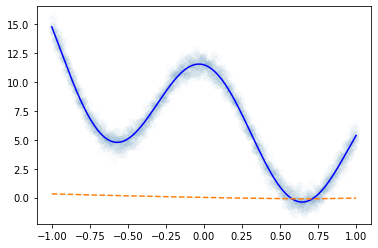

In [88]:
loss_fn = torch.nn.MSELoss() 

optimizr = torch.optim.Adam(net.parameters())

plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

In [89]:
for epoc in range(6000): 
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

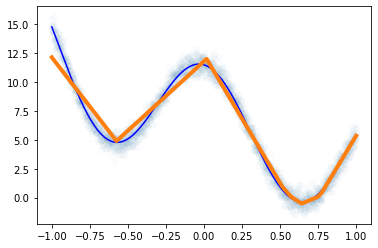

In [90]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,lw=4)

> local min에 빠졌다
  - epochs을 늘려도 적합선은 눈에 띄게 변하지 않는다

---

(풀이2) -- 풀이1보다 좀 더 잘맞음. 잘 맞는 이유? 좋은초기값 (=운) 

In [91]:
torch.manual_seed(5)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32), # x:(n,1) --> u1:(n,32)
    torch.nn.ReLU(), # u1:(n,32) --> v1:(n,32) 
    torch.nn.Linear(in_features=32,out_features=1) # v1:(n,32) --> u2:(n,1)
)

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [92]:
loss_fn = torch.nn.MSELoss() 

In [93]:
optimizr = torch.optim.Adam(net.parameters())

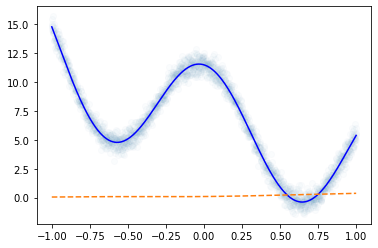

In [94]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

In [95]:
for epoc in range(6000): 
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

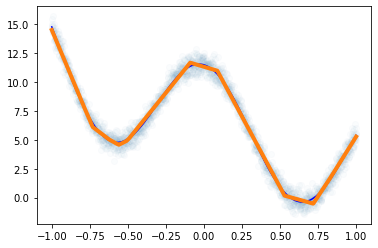

In [96]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,lw=4)

> 풀이1에서 에폭을 많이 반복하면 풀이2의 적합선이 나올까? --> 안나옴!! (local min에 빠졌다) 

### 예제3

<AxesSubplot:xlabel='x1', ylabel='x2'>

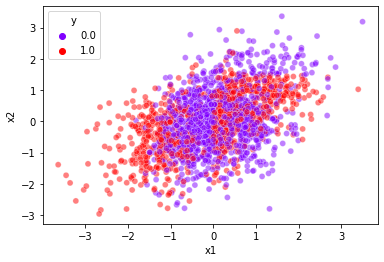

In [110]:
import seaborn as sns
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex3.csv')
sns.scatterplot(data=df,x='x1',y='x2',hue='y',alpha=0.5,palette={0:(0.5, 0.0, 1.0),1:(1.0,0.0,0.0)})

In [111]:
x1 = torch.tensor(df.x1).float().reshape(-1,1) 
x2 = torch.tensor(df.x2).float().reshape(-1,1) 
X = torch.concat([x1,x2],axis=1) 
y = torch.tensor(df.y).float().reshape(-1,1) 

In [112]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=2,out_features=32),# in_features가 2 ! = X.shape = (2000,2)
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid()
)

- $\underset{(n,2)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [113]:
loss_fn = torch.nn.BCELoss() 

In [114]:
optimizr = torch.optim.Adam(net.parameters()) 

In [115]:
for epoc in range(3000):
    loss = loss_fn(net(X),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad() 

In [116]:
df2 = df.assign(yhat=yhat.reshape(-1).detach().tolist())
df2

,x1,x2,y,yhat
0,-0.874139,0.210035,0.0,0.344423
1,-1.143622,-0.835728,1.0,0.604281
2,-0.383906,-0.027954,0.0,0.110590
3,2.131652,0.748879,1.0,0.920506
4,2.411805,0.925588,1.0,0.918970
...,...,...,...,...
1995,-0.002797,-0.040410,0.0,0.260841
1996,-1.003506,1.182736,0.0,0.489265
1997,1.388121,0.079317,0.0,0.403746
1998,0.080463,0.816024,1.0,0.263182


<AxesSubplot:xlabel='x1', ylabel='x2'>

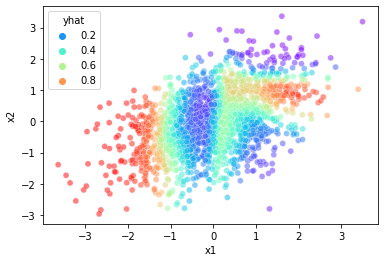

In [118]:
sns.scatterplot(data=df2,x='x1',y='x2',hue='yhat',alpha=0.5,palette='rainbow')

`-` 결과시각화 

<AxesSubplot:xlabel='x1', ylabel='x2'>

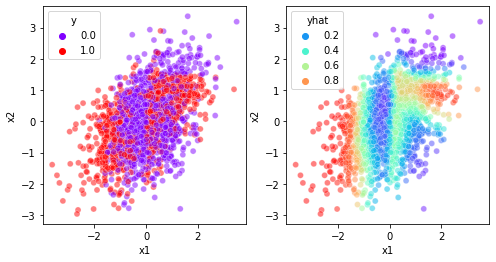

In [119]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.scatterplot(data=df,x='x1',y='x2',hue='y',alpha=0.5,palette={0:(0.5, 0.0, 1.0),1:(1.0,0.0,0.0)},ax=ax[0])
sns.scatterplot(data=df2,x='x1',y='x2',hue='yhat',alpha=0.5,palette='rainbow',ax=ax[1])

In [120]:
from fastai.data.all import * 
import torchvision
import numpy as np

## 시벤코정리 

`-` 아이디어: linear -> relu -> linear (-> sigmoid) 조합으로 꺾은선으로 표현되는 underlying 을 표현할 수 있었다. 
- 아이디어의 실용성: 실제자료에서 꺾은선으로 표현되는 underlying은 몇개 없을 것 같음. 
  - 그건 맞는데 꺾이는 점을 많이 설정하면 얼추 비슷하게는 "근사" 시킬 수 있음. 
- 아이디어의 확장성: 이러한 논리전개는 X: (n , 2)인 경우도 가능했음. 즉, 입력 차원이 2인 경우
- 아이디어에 해당하는 용어정리: : 이 구조가 x->y 로 바로 가는 것이 아니라 x->(u1->v1)->(u2->v2)=y 의 구조인데 
  - ### `이러한 네트워크를 하나의 은닉층을 포함하는 네트워크라고 표현한다.`
    - ### `총 layer의 수(학습할 parameter가 있는 층) = 은닉층의 수 + 출력층의 수`

### 시벤코정리

**universal approximation thm: (범용근사정리,보편근사정리,시벤코정리)**, 1989

> 하나의 은닉층을 가지는 "linear -> sigmoid -> linear" 꼴의 네트워크를 이용하여 세상에 존재하는 모든 (다차원) 연속함수를 원하는 정확도로 근사시킬 수 있다. (계수를 잘 추정한다면)


`-` 사실 엄청 이해안되는 정리임. 왜냐햐면,
- 그렇게 잘 맞추면 1989년에 세상의 모든 문제를 다 풀어야 한거 아니야? 
- 요즘은 "linear -> sigmoid -> linear" 가 아니라 "linear -> relu -> linear" 조합으로 많이 쓰던데? 
- 요즘은 하나의 은닉층을 포함하는 네트워크는 잘 안쓰지 않나? 은닉층이 여러개일수록 좋다고 어디서 본 것 같은데?

`-` 약간의 의구심이 있지만 아무튼 universal approximation thm에 따르면 우리는 아래와 같은 무기를 가진 꼴이 된다. 
- 우리의 무기: ${\bf X}: (n,p)$ 꼴의 입력에서 ${\bf y}:(n,1)$ 꼴의 출력으로 향하는 맵핑을 "linear -> relu -> linear"와 같은 네트워크를 이용해서 "근사"시킬 수 있다.

## MNIST with DNN

`-` 목표: 
- ${\bf X}:(n,1,28,28)$ 에서 $y:(n,1)$ 로 가는 맵핑을 학습하자 
- --> 배운적이 없는데? 
- --> ${\bf X}:(n,784)$ 에서 $y:(n,1)$ 로 가는 맵핑을 학습하자.. 

### 예비학습1: Path

In [122]:
path = untar_data(URLs.MNIST) 
path
# path도 오브젝트임 -> 따라서 path도 정보와 기능이 있다

Path('/Users/gwagdoseong/.fastai/data/mnist_png')

In [123]:
path.ls() # 폴더 2개가 있다

(#2) [Path('/Users/gwagdoseong/.fastai/data/mnist_png/training'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing')]

In [124]:
path.ls()[0] # 첫 번째 폴더의 주소

Path('/Users/gwagdoseong/.fastai/data/mnist_png/training')

In [125]:
path.ls()[1] # 두 번째 폴더의 주소

Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing')

In [126]:
path.ls()[1].ls() # 두 번째 폴더에 또 10개의 폴더가 들어있다

(#10) [Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/9'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/0'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/7'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/6'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/1'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/8'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/4'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/3'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/2'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/5')]

In [127]:
path/'training'

Path('/Users/gwagdoseong/.fastai/data/mnist_png/training')

In [128]:
path/'testing'

Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing')

In [129]:
(path/'testing').ls()

(#10) [Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/9'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/0'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/7'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/6'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/1'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/8'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/4'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/3'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/2'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/testing/5')]

In [130]:
(path/'training/3').ls()
# 3이라는 폴더에 6131개의 이미지 파일이 들어있음

(#6131) [Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/49081.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/51816.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/39566.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/24251.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/20989.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/29013.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/58832.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/9294.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/20023.png'),Path('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/36899.png')...]

### 예비학습2: plt.imshow 

In [133]:
imgtsr = torch.tensor([[1.0,2.0],[2.0,4.0]])
imgtsr # 2x2의 행렬

tensor([[1., 2.],
        [2., 4.]])

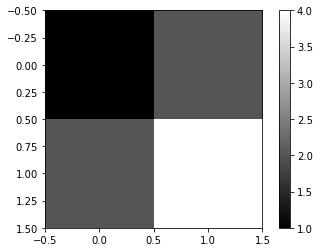

In [134]:
plt.imshow(imgtsr,cmap='gray')
plt.colorbar()

### 예비학습3: torchvision

`-` 이미지파일을 torchvision.io.read_image 를 이용하여 텐서로 만듦

In [135]:
imgtsr = torchvision.io.read_image('/Users/gwagdoseong/.fastai/data/mnist_png/training/3/49081.png')
imgtsr

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0, 104, 253, 253, 253, 121,
          121,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,  30, 156, 252, 252, 253,
          252, 247, 240, 240, 240, 148,  39,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

`-` 이 텐서는 (1,28,28)의 shape을 가짐

In [136]:
imgtsr.shape
# 맨 앞의 1은 RGB가 아니라 흑백이라서 1인 것

torch.Size([1, 28, 28])

`-` imgtsr를 plt.imshow 로 시각화

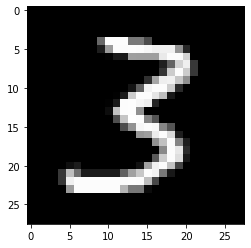

In [143]:
plt.imshow(imgtsr.reshape(28,28),cmap='gray')

### 데이터정리 

In [144]:
threes = (path/'training/3').ls()
sevens = (path/'training/7').ls()
len(threes),len(sevens)

(6131, 6265)

In [145]:
X3 = torch.stack([torchvision.io.read_image(str(threes[i])) for i in range(6131)])
X7 = torch.stack([torchvision.io.read_image(str(sevens[i])) for i in range(6265)])

# 숫자 3과 숫자 7의 tensor를 저장

In [146]:
X3.shape,X7.shape

(torch.Size([6131, 1, 28, 28]), torch.Size([6265, 1, 28, 28]))

In [147]:
X=torch.concat([X3,X7])
X.shape

torch.Size([12396, 1, 28, 28])

In [149]:
Xnp = X.reshape(-1,1*28*28).float()
Xnp.shape
# 12396장을 784개의 feature로 바꿨음

torch.Size([12396, 784])

In [150]:
y = torch.tensor([0.0]*6131 + [1.0]*6265).reshape(-1,1) 
y.shape
# 0은 숫자 3의 label, 1은 숫자 7의 label

torch.Size([12396, 1])

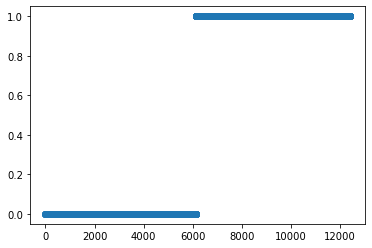

In [151]:
plt.plot(y,'o')

`-` 네트워크의 설계

In [152]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)

- $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [153]:
loss_fn = torch.nn.BCELoss()

In [154]:
optimizr = torch.optim.Adam(net.parameters())

In [155]:
for epoc in range(200):
    loss = loss_fn(net(Xnp),y) 
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

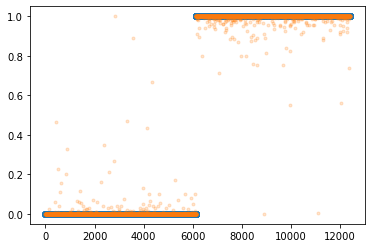

In [156]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

- 대부분 잘 적합되었음 

---

## 숙제 

(1) 숫자0과 숫자1을 구분하는 네트워크를 아래와 같은 구조로 설계하라

$$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,64)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,64)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

위에서 $a_1$은 relu를, $a_2$는 sigmoid를 의미한다. 

- "y=0"은 숫자0을 의미하도록 하고 "y=1"은 숫자1을 의미하도록 설정하라. 

In [157]:
zeros = (path/'training/0').ls()
ones = (path/'training/1').ls()

X0 = torch.stack([torchvision.io.read_image(str(zeros[i])) for i in range(len(zeros))])
X1 = torch.stack([torchvision.io.read_image(str(ones[i])) for i in range(len(ones))])


X=torch.concat([X0,X1])


Xnp = X.reshape(-1,1*28*28).float()


y = torch.tensor([0.0]*len(zeros) + [1.0]*len(ones)).reshape(-1,1) 


net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1*28*28,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid()
)

(2) 아래의 지침에 따라 200 epoch 학습을 진행하라.
- 손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss() 를 이용할 것. 
- 옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것. 

In [158]:
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [159]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

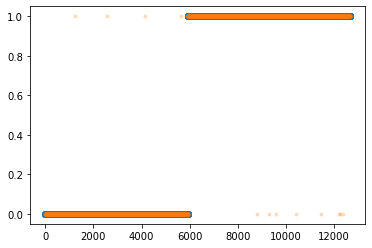

In [160]:
plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

(3) 아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가? 
- 손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고 수식을 직접 입력할 것.
- 옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것. 

In [161]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1*28*28,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid())

In [162]:
def loss_fn(y,yhat):
    return -torch.mean(y*torch.log1p(yhat) + (1-y)*torch.log1p(1-yhat))

optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [163]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

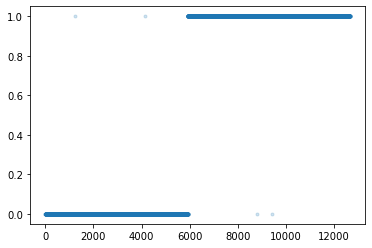

In [164]:
#plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

In [165]:
def accuracy(x):
    for i in range(len(x)):
        if x[i] > 0.5 :
            x[i] = 1 
        else : 
            x[i] = 0
    return np.array(y==x).mean()

accuracy(net(Xnp))

0.9996841689696012

(4) 아래의 지침에 따라 200 epoch 학습을 진행하라. 학습이 잘 되는가? 
- 이미지의 값을 0과 1사이로 규격화 하라. (Xnp = Xnp/255 를 이용하세요!)
- 손실함수는 BECLoss를 이용할 것. torch.nn.BCELoss()를 사용하지 않고 수식을 직접 입력할 것.
- 옵티마이저는 아담으로 설정할 것. 학습률은 lr=0.002로 설정할 것. 

In [178]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1*28*28,out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64,out_features=1),
    torch.nn.Sigmoid())

In [179]:
def loss_fn(y,yhat):
    return -torch.mean(y*torch.log1p(yhat) + (1-y)*torch.log1p(1-yhat))
optimizr = torch.optim.Adam(net.parameters(),lr=0.002)

In [180]:
Xnp = Xnp/255

In [181]:
for epoc in range(200):
    ## 1
    yhat = net(Xnp) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

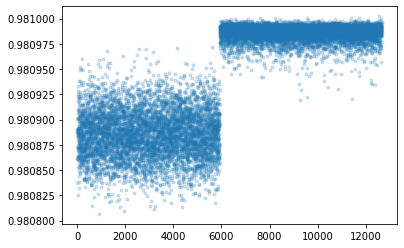

In [182]:
# plt.plot(y,'o')
plt.plot(net(Xnp).data,'.',alpha=0.2)

(5) 아래와 같은 수식을 이용하여 accuracy를 계산하라. 

$\text{accuracy}=\frac{1}{n}\sum_{i=1}^n I(\tilde{y}_i=y_i)$
- $\tilde{y}_i = \begin{cases}
 1 & \hat{y}_i > 0.5 \\ 
 0 & \hat{y}_i \leq 0.5 
\end{cases}$ 
- $I(\tilde{y}_i=y_i) = \begin{cases} 1 & \tilde{y}_i=y_i \\ 0 & \tilde{y}_i \neq y_i \end{cases}$

단, $n$은 0과 1을 의미하는 이미지의 수 

In [183]:
def accuracy(x):
    for i in range(len(x)):
        if x[i] > 0.5 :
            x[i] = 1 
        else : 
            x[i] = 0
    return np.array(y==x).mean()

accuracy(net(Xnp))

0.5323332017370707

----

# 질문..

- BCE 수식 직접 입력할 때 안 되면 log1p썼는데 되는 건 뭐고 안 되는 건 뭐?
- 그리고 규격화하면 학습 잘 된다며?
